WY1925 - 2011 PCA.

In [19]:
%matplotlib inline

In [20]:
import sys
sys.path.append('..')

import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import seaborn as sns
import xarray as xr
import tools

In [21]:
sns.set_style('whitegrid')
mpl.rcParams['axes.unicode_minus'] = False  # Otherwise the "-" don't render on PDF figures
mpl.rcParams.update({'font.size': 6})  # GRL figure font-size.
mpl.rcParams.update({'axes.titlesize': 'medium',
                     'axes.labelsize': 'medium',
                     'legend.fontsize': 'medium',
                     'xtick.labelsize': 'medium',
                     'ytick.labelsize': 'medium'})  # GRL figure font-size.

In [22]:
DB_PATH = '../data/stationdb.sqlite'
HGT_PATH = '../data/tcrv2_z500_season.nc'
SST_PATH = '../data/ersstv3b_season.nc'
PC1975_PATH = '../data/pc_1975.csv'
WESTOFLON = -104
EASTOFLON = -125
WATER_YEAR = {'low': 1925,
              'high': 2011}
WY_RANGE = np.arange(WATER_YEAR['low'], WATER_YEAR['high'] + 1)
CAL_YEAR = {'low': WATER_YEAR['low'] - 1,
            'high': WATER_YEAR['high']}

In [23]:
# Grab data from SQLITE3 DB.
target_stations = tools.check_wy(DB_PATH, WATER_YEAR['low'], WATER_YEAR['high'], 
                                 WESTOFLON, EASTOFLON)
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT site_no, year_nu, mean_va FROM StationWY 
               WHERE year_nu <= {wy_high} AND year_nu >= {wy_low} AND site_no IN ({seq}) 
               GROUP BY site_no, year_nu 
               ORDER BY site_no, year_nu ASC""".format(wy_low = str(WATER_YEAR['low']), 
                                                       wy_high = str(WATER_YEAR['high']), 
                                                       seq = ','.join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, 
                  params = target_stations, 
                  index_col = ['year_nu', 'site_no'])
conn.close()

In [24]:
raw.unstack(level = -1).to_csv('../data/streamflow_1925.csv')

In [25]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT "STATION ID", LAT_GAGE, LONG_GAGE FROM StationInfo 
               WHERE "STATION ID" IN ({seq}) 
               ORDER BY "STATION ID" ASC""".format(seq = ','.join(['?'] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map

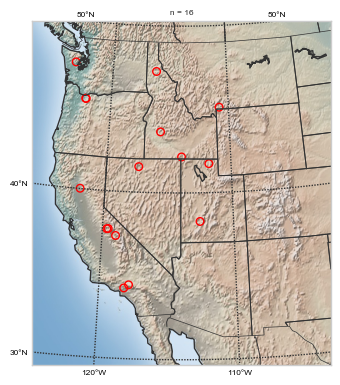

In [26]:
out = tools.plot_gagesmap(latlon['LAT_GAGE'].as_matrix(), latlon['LONG_GAGE'].as_matrix())

## KS-Test for non-gamma distributed streamflow

site_no
10263500    0.011485
Name: mean_va, dtype: float64


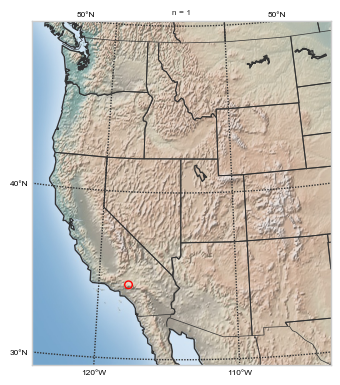

In [27]:
kspvals = raw.groupby(level = 'site_no')['mean_va'].aggregate(tools.adj_gamma_kstest)
# latlon of gages which do not fit gamma.
print(kspvals[kspvals <= 0.05])
non_gamma = latlon[latlon['STATION ID'].isin(kspvals[kspvals <= 0.05].index.values)]
out = tools.plot_gagesmap(non_gamma['LAT_GAGE'].as_matrix(), non_gamma['LONG_GAGE'].as_matrix())

## Test for peak runoff

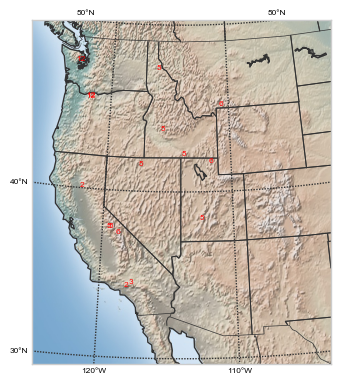

In [28]:
# Plots integers in map giving the month with max average discharge. Gives us an 
# idea about the seasonality of flow.
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT site_no, year_nu, month_nu, mean_va FROM StationMonthly 
               WHERE year_nu <= {cal_high} AND year_nu >= {cal_low} AND site_no IN ({seq}) 
               ORDER BY site_no, year_nu, month_nu ASC""".format(cal_low = str(CAL_YEAR['low']), 
                                                                 cal_high = str(CAL_YEAR['high']), 
                                                                 seq = ",".join(["?"] * len(target_stations)))
monthly_flows = pd.read_sql(sql_query, conn, 
                            params = target_stations, 
                            index_col = ['site_no', 'year_nu', 'month_nu'])
conn.close()
monthly_mean = monthly_flows.groupby(level = ['site_no', 'month_nu']).mean()
# Get month with max flow for each station.
max_month = monthly_mean.groupby(level = 'site_no').idxmax()['mean_va'].apply(lambda a: a[1])

# Join max months with latlon data.
max_month = latlon.join(max_month, on = 'STATION ID')

# Plot data on map
fig = plt.figure(figsize = (3.74016, 4.52756))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
m = Basemap(width = 2000000, height = 2300000, 
            resolution = 'l', projection = 'stere', 
            lat_ts = 40.0, 
            lat_0 = 40.0, lon_0 = -114.0)
m.drawcoastlines(color = '#333333')
m.drawstates(linewidth = 0.7, color = '#333333')
m.drawcountries(color = '#333333')
m.shadedrelief()
parallels = np.arange(0., 81, 10)
m.drawparallels(parallels, labels = [True, False, True, False], color = '#333333')
meridians = np.arange(10., 351., 10)
m.drawmeridians(meridians, labels = [False, True, False, True], color = '#333333')
for r in max_month.iterrows():
    x, y = m(r[1]['LONG_GAGE'], r[1]['LAT_GAGE'])  # A bit slow. Should do all at once.
    plt.text(x, y, int(r[1]['mean_va']), color = 'r')
plt.show()

## Standardize streamflow

In [29]:
# parsed = raw.groupby(level = 'site_no')['mean_va'].transform(tools.spigamma)
# parsed = parsed.groupby(level = 'site_no').transform(lambda x: signal.detrend(x.values, type = 'linear'))


parsed = raw.groupby(level = 'site_no')['mean_va'].transform(tools.spigamma)
# parsed = raw.groupby(level = 'site_no')['mean_va'].transform(tools.zscore)

## Basic North Test scree plot

In [30]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.
examine_modes = 10
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

In [31]:
pc = pd.DataFrame(pc,
                  columns = ['PC' + str(i + 1) for i in range(examine_modes)],
                  index = pd.Index(WY_RANGE, name = 'wy'))
pc.to_csv('../data/pc_1925.csv', index = True)

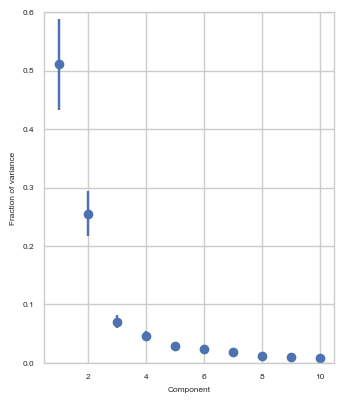

In [32]:
out = tools.plot_northtest(solver, nmodes = examine_modes)

In [33]:
retain_modes = 2

## PC time series from leading components

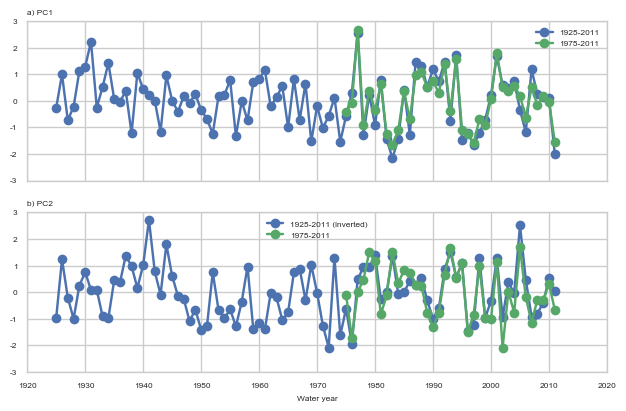

In [34]:
test_1975 = pd.read_csv(PC1975_PATH)

fig, axes = plt.subplots(figsize = (7.48031, 4.52756), nrows = 2, ncols = 1, sharex = True, sharey = True)

axes.flat[0].plot(pc.reset_index()['wy'], pc['PC1'], '-o', label = '1925-2011')
axes.flat[0].plot(test_1975['wy'], test_1975['PC1'], '-o', label = '1975-2011')
axes.flat[0].set_title('a) PC1', loc = 'left')
axes.flat[1].plot(pc.reset_index()['wy'], -pc['PC2'], '-o', label = '1925-2011 (inverted)')
axes.flat[1].plot(test_1975['wy'], test_1975['PC2'], '-o', label = '1975-2011')
axes.flat[1].set_title('b) PC2', loc = 'left')
axes.flat[0].legend()
axes.flat[1].legend(loc = 'upper center')
axes.flat[1].set_xlabel('Water year')
axes.flat[0].xaxis.set_ticks(np.arange(1920, 2030, 10))

plt.savefig('../plots/s4.pdf', dpi = 300)

## Leading EOFs mapped as covariance

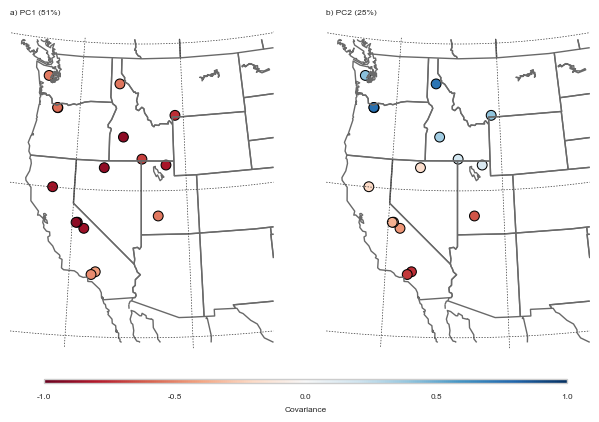

In [35]:
out = tools.plot_eof(solver, 
                     lat = latlon["LAT_GAGE"].as_matrix(),
                     lon = latlon["LONG_GAGE"].as_matrix(), 
                     nmodes = retain_modes)
plt.savefig("../plots/s1.pdf", dpi = 300)

# Point correlation & composite maps

Here, we're flipping PC2 so that it matches PC2 in the original PCA.

In [36]:
pc.loc[:, 'PC2'] = -pc['PC2']

The uncertainty in pre-1950s TCR really shows in this 1925 PCA.

In [37]:
with xr.open_dataset(HGT_PATH) as hgt:
    hgt_anom = hgt.z500[np.in1d(hgt['wy'], WY_RANGE)].copy()

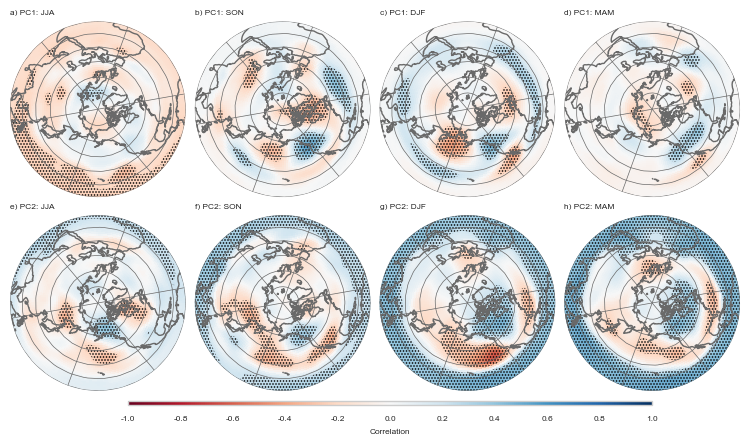

In [38]:
hgt_corrs = tools.pointfield_corr(field = hgt_anom, pc_df = pc)
out = tools.plot_pointfield_corr(hgt_corrs, map_type = 'north_hemisphere')
plt.savefig("../plots/s5.pdf", dpi = 300)

<xarray.DataArray 'Composite difference (m)' ()>
array(-52.355779427360176)
<xarray.DataArray 'Composite difference (m)' ()>
array(40.82803110639725)


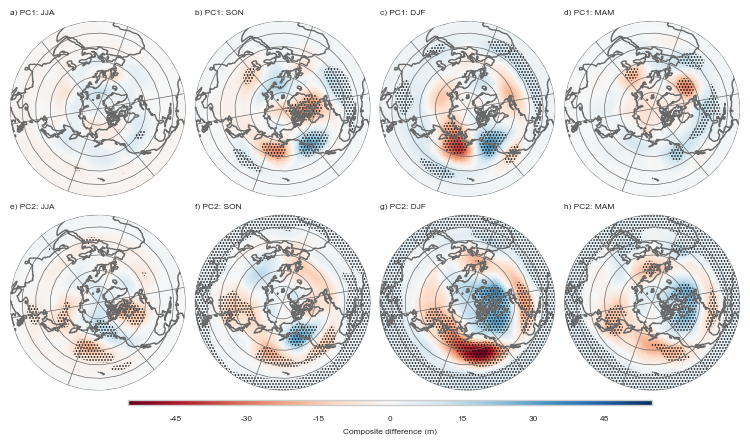

In [39]:
stat_str = 'Composite difference (m)'
hgt_ttest = tools.pointfield_ttest(stat_name = stat_str,
                                   field = hgt_anom, 
                                   pc_df = pc)

out = tools.plot_pointfield_ttest(hgt_ttest, 
                                  map_type = 'north_hemisphere', 
                                  stat_name = stat_str,
                                  vmin = -55, vmax = 55)

plt.savefig("../plots/s7.pdf", dpi = 300)

print(hgt_ttest[stat_str].min())
print(hgt_ttest[stat_str].max())

In [40]:
with xr.open_dataset(SST_PATH) as ersst:
    sst_anom = ersst.sst[np.in1d(ersst['wy'], WY_RANGE)].copy()

There might be a RuntimeWarning below. This is from NaNs over the poles in SST fields.

/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


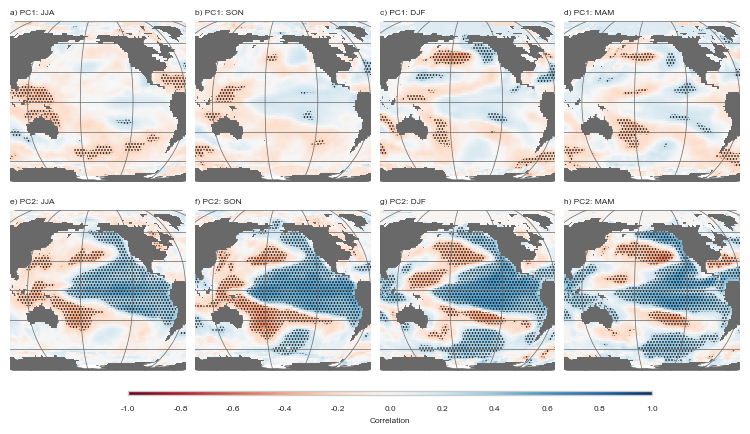

In [41]:
sst_corrs = tools.pointfield_corr(field = sst_anom, pc_df = pc)
out = tools.plot_pointfield_corr(sst_corrs, map_type = 'global')
plt.savefig("../plots/s6.pdf", dpi = 300)

/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverp

<xarray.DataArray 'Composite difference (°C)' ()>
array(-0.7219845970859335)
<xarray.DataArray 'Composite difference (°C)' ()>
array(1.3752331953205887)


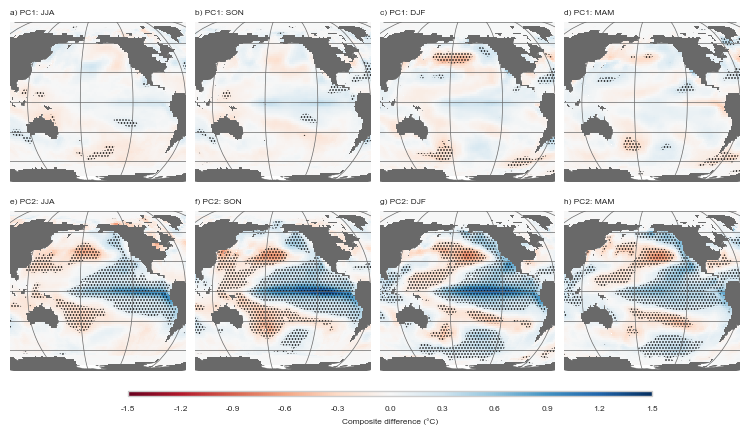

In [42]:
stat_str = 'Composite difference (°C)'
sst_ttest = tools.pointfield_ttest(stat_name = stat_str,
                                   field = sst_anom, 
                                   pc_df = pc)

out = tools.plot_pointfield_ttest(sst_ttest, 
                                  map_type = 'global', 
                                  stat_name = stat_str,
                                  vmin = -1.5, vmax = 1.5)

plt.savefig("../plots/s8.pdf", dpi = 300)

print(sst_ttest[stat_str].min())
print(sst_ttest[stat_str].max())